In [1]:
import torch

import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from plot import draw_apparatus
from image_data_helpers import get_data, get_dataset
from mpl_toolkits.axes_grid1 import ImageGrid

import time
from tqdm import tqdm

%matplotlib inline

## Epoch testing code

The number of epochs required to train autoencoder models will be verified in this notebook. This requires a set dataset with a specific excluded validation set, and a specific model. Performance will be evaluated by training the model over 100 , 1000, 10000, and 20000 epochs to determine when overfitting happens (validation score >> train score). In addition, model performance also needs to be evaluated by examining the predicted profiles. 

In [3]:
def plot_data(data):
    from plot import draw_apparatus
    fig, ax = plt.subplots(ncols=5, sharey=True)
    for i in range(5):
        ax[i].imshow(data[i, :, :], origin='lower', extent=[0, 20, 0, 70.7])
        draw_apparatus(ax[i])

    return fig

In [5]:
test = get_dataset(300, 80) 

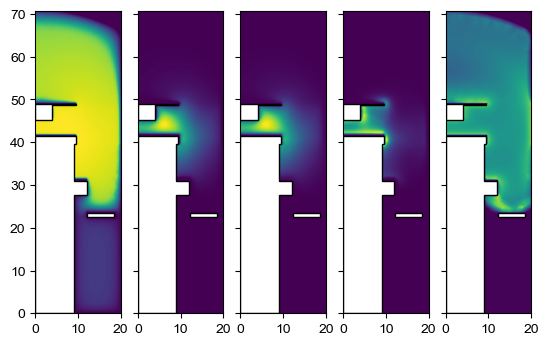

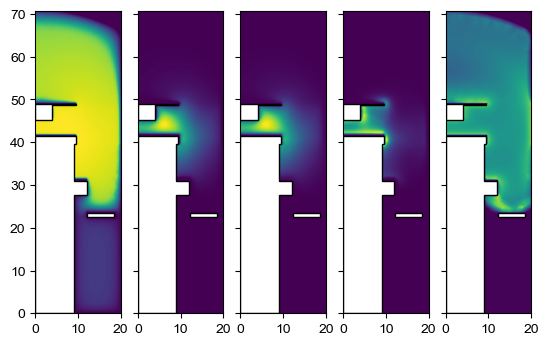

In [6]:
plot_data(test)

### To do:
* plot train and validation error (I can probably just use the one in plot.py)
* plot images

In [7]:
test.shape

(5, 707, 200)

In [8]:
def crop(image, corner=(0, 350), width=200, height=200):
    # image shape = 5, 707, 200
    """Crop images to desired size (x and y). 

    Assumes input images with a shape of (channels, height, width).

    Args:
        image (np.ndarray): Image to be cropped.
        corner (Tuple[int, int]): Location of the lower-left corner for the cropping.
        width (Crop width): Width of the crop.
        height (Crop height): Height of the crop.

    Returns:
        np.ndarray: Cropped n-channel image.
    """    
    startx, starty = corner

    endx = startx + width
    endy = starty + height

    return image[:, starty:endy, startx:endx]


In [9]:
crop(test, (0, 350), 200, 200).shape

(5, 200, 200)

In [10]:
def plot_crop(data, cbar=None):
    fig = plt.figure()

    grid = ImageGrid(fig, 111,  # similar to fig.add_subplot(142).
                     nrows_ncols=(1, 5), axes_pad=0.0, label_mode="L", share_all=True,
                     cbar_location="right", cbar_mode=cbar, cbar_size="5%", cbar_pad='5%')

    for i, ax in enumerate(grid):
        im = ax.imshow(data[i, :, :], origin='lower', 
                       extent=[0, 20, 35, 55], cmap='magma')
        draw_apparatus(ax)

    grid.cbar_axes[0].colorbar(im)

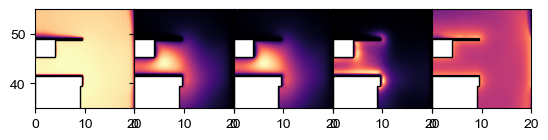

In [11]:
cropped = crop(test, (0, 350), 200, 200)
plot_crop(cropped)

In [12]:
def downscale(image_stack, resolution):
    import cv2
    data = np.stack([cv2.resize((np.moveaxis(image, 0, -1)), (resolution, resolution)) for image in image_stack])
    return np.moveaxis(data, -1, 1)  # revert moveaxis operation

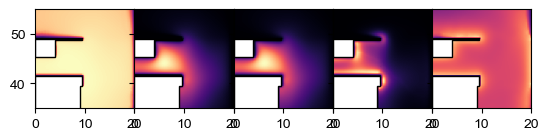

In [13]:
scaled = downscale(cropped, 64)
plot_crop(scaled)

In [14]:
nc_path = root/'data'/'interpolation_datasets'/'full_interpolation.nc'
ds = xr.open_dataset(nc_path)
ds

<xarray.Dataset>
Dimensions:        (y: 707, x: 200, P: 8, V: 4)
Coordinates:
  * y              (y) float64 0.0 0.001 0.002 0.003 ... 0.703 0.704 0.705 0.706
  * x              (x) float64 0.0 0.001 0.002 0.003 ... 0.196 0.197 0.198 0.199
  * P              (P) float64 5.0 10.0 30.0 45.0 60.0 80.0 100.0 120.0
  * V              (V) float64 200.0 300.0 400.0 500.0
Data variables:
    potential (V)  (V, P, y, x) float64 ...
    Ne (#/m^-3)    (V, P, y, x) float64 ...
    Ar+ (#/m^-3)   (V, P, y, x) float64 ...
    Nm (#/m^-3)    (V, P, y, x) float64 ...
    Te (eV)        (V, P, y, x) float64 ...

In [16]:
ds['potential (V)'].sel(V=300, P=60).values.shape

(707, 200)

In [18]:
np.stack([np.nan_to_num(ds[variable].sel(V=300, P=60).values) for variable in list(ds.keys())]).shape

(5, 707, 200)

In [20]:
np.nan_to_num(ds['potential (V)'].values).shape

(4, 8, 707, 200)

In [21]:
for variable in list(ds.keys()):
    var_data = np.nan_to_num(ds[variable].values)
    print(var_data.min())
    print(var_data.max())
    print('\n')

-1.2891021583527617e-14
205.71708513606058


0.0
1.675699409702132e+16


0.0
1.6757694097021318e+16


0.0
8.549053831954201e+18


0.0
11.672450000000012




In [22]:
def minmax_scale(image):

    scaled_arrays = []

    for i, variable in enumerate(list(ds.keys())):

        var_data = np.nan_to_num(ds[variable].values)
        a = 0.0  # force 0 minimum
        b = var_data.max()

        data_array = image[i, :, :]

        # minmax scale
        scaled_arrays.append((data_array-a) / (b - a))

    scaled = np.stack(scaled_arrays)

    assert scaled.shape == image.shape

    return scaled


In [25]:
cropped.shape

(5, 200, 200)

In [24]:
minmax = minmax_scale(cropped)
minmax.shape

(5, 200, 200)

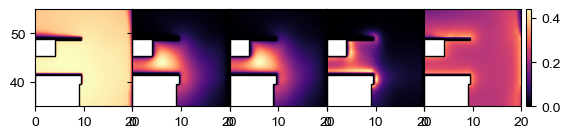

In [19]:
plot_crop(minmax, 'single')

In [20]:
print(list(ds.V.values))
print(list(ds.P.values))

[200.0, 300.0, 400.0, 500.0]
[5.0, 10.0, 30.0, 45.0, 60.0, 80.0, 100.0, 120.0]


In [21]:
if torch.cuda.is_available(): 
    device = "cuda:0" 
elif torch.backends.mps.is_available():
    device = 'mps'
else: 
    device = "cpu" 

device

'cuda:0'

In [22]:
v_list = [200.0, 300.0, 400.0, 500.0]
p_list = [5.0, 10.0, 30.0, 45.0, 60.0, 80.0, 100.0, 120.0]

vps = [(v, p) for v in v_list for p in p_list]

# load train and validation sets
validation_pair = (400.0, 45.0)
test_pair = (300.0, 60.0)

train_images = []
for vp in vps:
    image = get_dataset(vp[0], vp[1])  # load data
    image = minmax_scale(downscale(crop(image), 64))  # crop, downscale, minmax
    if vp == test_pair:  # test set
        test_image = torch.tensor(np.expand_dims(image, axis=0), dtype=torch.float32, device=device) # convert to tensor
    elif vp == validation_pair:  # validation set
        val_image = torch.tensor(np.expand_dims(image, axis=0), dtype=torch.float32, device=device)
    else:
        train_images.append(image)

train_set = torch.tensor(np.stack(train_images), dtype=torch.float32, device=device)

In [29]:
list(ds.V.values)

[200.0, 300.0, 400.0, 500.0]

In [23]:
test_image.size()

torch.Size([1, 5, 64, 64])

In [24]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(train_set)
trainloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [25]:
# training hyperparameters
conf_dict = {'epochs':10000, 'learning_rate':1e-3}

In [26]:
from autoencoder_classes import A64_6
import torch.nn as nn
import torch.optim as optim

epochs = conf_dict['epochs']
learning_rate = conf_dict['learning_rate']
model = A64_6().to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
epoch_loss = []
epoch_validation = []
epoch_times = []
loop = tqdm(range(epochs), desc='Training...', unit='epoch', colour='#7dc4e4')

train_start = time.perf_counter()
for epoch in loop:
    # loop = tqdm(trainloader)
    epoch_start = time.time()
    for i, batch_data in enumerate(trainloader):
        # get inputs
        inputs = batch_data[0]
        optimizer.zero_grad()

        # record loss
        running_loss = 0.0

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}/{epochs}")

    with torch.no_grad():
        val_loss = criterion(model(val_image), val_image).item()

    epoch_validation.append(val_loss)
    epoch_loss.append(running_loss)
    epoch_end = time.time()
    epoch_times.append(time.time()-epoch_start)

    # if (epoch+1) % epochs == 0:
    #     # save model every 10 epochs (so i dont lose all training progress in case i do something unwise)
    #     # pytorch checkpoints
    #     torch.save(model.state_dict(), out_dir/f'{name}')

train_end = time.perf_counter()
print(f'training finished in {train_end-train_start} s')

Epoch 2728/10000:  27%|██▋       | 2727/10000 [08:44<20:43,  5.85epoch/s]

In [ ]:
def plot_train_loss(losses, validation_losses=None, out_dir=None):  # TODO: move to plot module

    losses = np.array(losses)
    fig, ax = plt.subplots(figsize=(10,4), dpi=200)
    ax.set_yscale('log')
    ax.plot(losses, c='k', label='train')

    if validation_losses is not None:
        ax.plot(validation_losses, c='r', ls=':', label='validation')
        ax.legend()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.grid()

    if out_dir is not None:
      fig.savefig(out_dir/'train_loss.png')

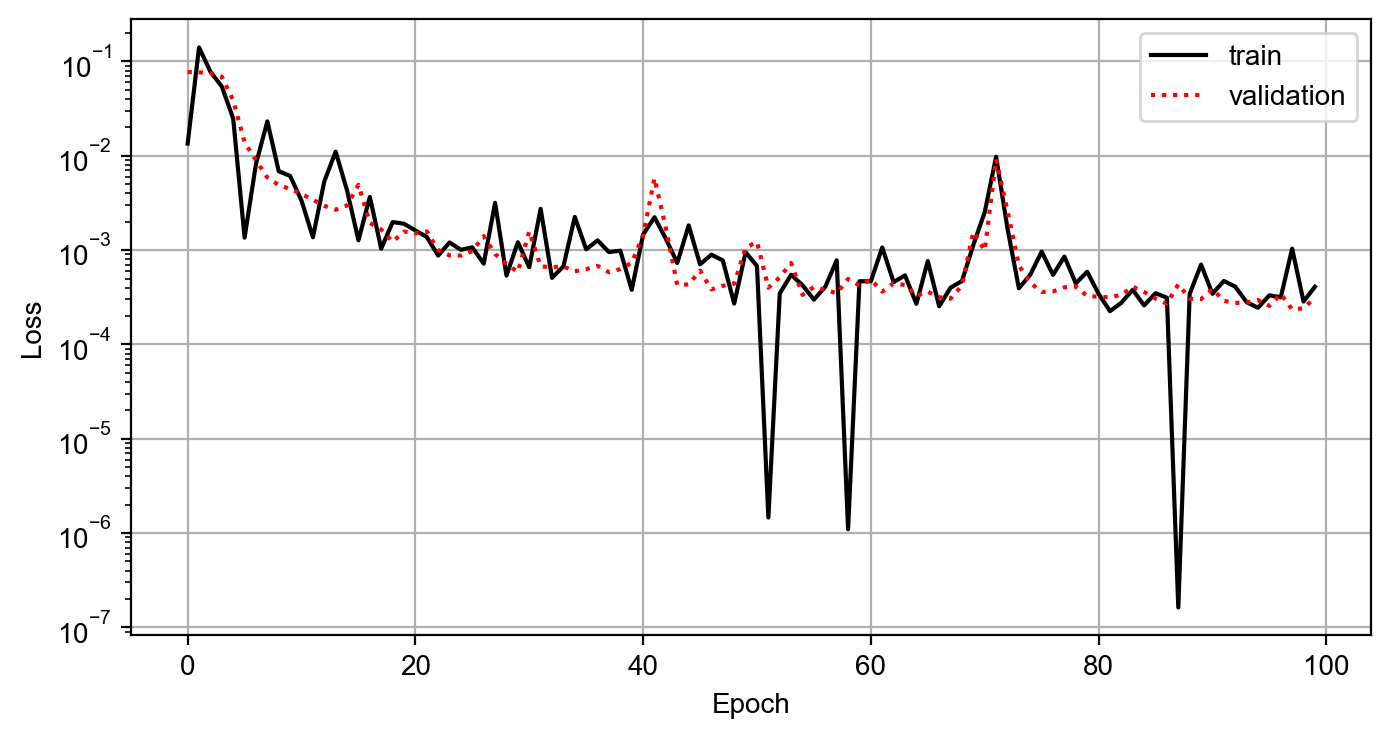

In [ ]:
plot_train_loss(epoch_loss, epoch_validation)